In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sqlalchemy as db
# from sqlalchemy import create_engine
# from sqlalchemy import MetaData 
# from sqlalchemy import Table

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=37) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
#shuffle data
labeled_data_sampled = labeled_data.sample(n=10000, random_state=1)

In [3]:
engine = db.create_engine('sqlite:///save_LC.db', echo=False)
sqlite_connection = engine.connect()
metadata = db.MetaData()
data = db.Table('ZTFJ182806.98+011859.4', metadata, autoload=True, autoload_with=engine)
print(data.columns.keys())

['index', 'oid', 'expid', 'hjd', 'mjd', 'mag', 'magerr', 'catflags', 'filtercode', 'ra', 'dec', 'chi', 'sharp', 'filefracday', 'field', 'ccdid', 'qid', 'limitmag', 'magzp', 'magzprms', 'clrcoeff', 'clrcounc', 'exptime', 'airmass', 'programid']


In [4]:
metadata = db.MetaData()
metadata.reflect(bind=engine)
for table in metadata.sorted_tables:
    print(table)

ZTFJ182806.98+011859.4
ZTFJ185629.89-050650.2
ZTFJ192656.26+264100.6
ZTFJ194013.88+123401.3
ZTFJ200451.65-090628.4


In [5]:

#Equivalent to 'SELECT * FROM census'
query = db.select([data])
ResultProxy = sqlite_connection.execute(query)
ResultSet = ResultProxy.fetchall()


In [6]:
df = pd.DataFrame(ResultSet)
df.columns = ResultSet[0].keys()

In [13]:
circle_radius = 0.00028 # 1 arcsec = 0.00028 degress
t_format = "ipac_table"
table_format = "FORMAT=" + str(t_format)
flag_mask = 32768
mask = "BAD_CATFLAGS_MASK=" + str(flag_mask)
collect="COLLECTION="+"ztf_dr2"
numobs = "NOBS_MIN=20"
filter_band = "g"
label = []
SourceID =[]
start_time = time.time()
i = 100000
j = 100000
ra = labeled_data.RAdeg[i]
dec = labeled_data.DEdeg[i]
circle = "POS=CIRCLE"+"+"+str(ra)+"+"+str(dec)+"+"+str(circle_radius)
band = "BANDNAME="+ filter_band
params = circle + "&" +  mask + "&" + numobs + "&" + collect + "&" + table_format

url1= "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?" + params
data1 = pd.read_csv(url1, header=None, delim_whitespace=True, skiprows=55) # extract data
header = pd.read_csv(url1, header=None, sep='|', skiprows=50,usecols=range(1,25), nrows=1)
data1.columns = header.iloc[0].str.strip()


url2 = 'http://variables.cn:88/seldataz.php?SourceID=' + str(labeled_data.SourceID[j])
data2 = pd.read_csv(url2, header='infer')

In [14]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   oid          180 non-null    int64  
 1   expid        180 non-null    int64  
 2   hjd          180 non-null    float64
 3   mjd          180 non-null    float64
 4   mag          180 non-null    float64
 5   magerr       180 non-null    float64
 6   catflags     180 non-null    int64  
 7   filtercode   180 non-null    object 
 8   ra           180 non-null    float64
 9   dec          180 non-null    float64
 10  chi          180 non-null    float64
 11  sharp        180 non-null    float64
 12  filefracday  180 non-null    int64  
 13  field        180 non-null    int64  
 14  ccdid        180 non-null    int64  
 15  qid          180 non-null    int64  
 16  limitmag     180 non-null    float64
 17  magzp        180 non-null    float64
 18  magzprms     180 non-null    float64
 19  clrcoeff

In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SourceID  181 non-null    int64  
 1   RAdeg     181 non-null    float64
 2   DEdeg     181 non-null    float64
 3   HJD       181 non-null    float64
 4   mag       181 non-null    float64
 5   e_mag     181 non-null    float64
 6   flag      181 non-null    int64  
 7   band      181 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 11.4+ KB


In [16]:
print(labeled_data.SourceID[i])

100002


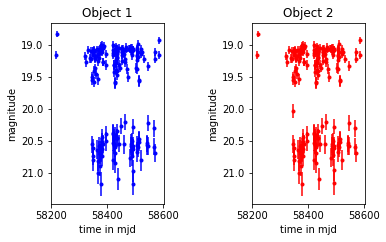

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
ax = axs[0]
ax.errorbar(data1['mjd'],data1['mag'],yerr = data1['magerr'],fmt='b.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel ('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 1')

ax = axs[1]
ax.errorbar(data2['HJD'],data2['mag'],yerr = data2['e_mag'],fmt='r.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 2')

fig.tight_layout(pad=3.0)
plt.show()

In [18]:
data1.head(100)

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
0,609101100000732,59746556,2.458352e+06,58351.465567,20.809130,0.162307,0,zg,72.528917,23.964330,...,1,1,21.120001,26.061207,0.038176,-0.018003,0.000022,30,1.360,1
1,609101100000732,61144565,2.458366e+06,58365.445660,20.642626,0.151627,0,zg,72.528926,23.964434,...,1,1,20.670000,26.126249,0.040681,-0.029009,0.000025,30,1.248,1
2,609101100000732,61448759,2.458369e+06,58368.487593,21.006998,0.174999,0,zg,72.528933,23.964382,...,1,1,21.549999,26.224461,0.028823,-0.086546,0.000012,30,1.077,1
3,609101100000732,61748893,2.458372e+06,58371.488935,20.650009,0.152100,0,zg,72.528970,23.964316,...,1,1,21.570000,26.225487,0.027173,-0.067458,0.000011,30,1.057,1
4,609101100000732,62047696,2.458375e+06,58374.476968,20.715414,0.156296,0,zg,72.528855,23.964379,...,1,1,21.360001,26.218786,0.029073,-0.064397,0.000012,30,1.065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,610104200001014,61246607,2.458367e+06,58366.466076,20.820005,0.151231,0,zg,72.528856,23.964358,...,4,2,21.270000,26.217695,0.027666,-0.052091,0.000012,30,1.237,1
96,610104200001014,61844903,2.458373e+06,58372.449039,20.581278,0.136421,0,zg,72.528918,23.964237,...,4,2,21.559999,26.244745,0.025546,-0.066080,0.000010,30,1.240,1
97,610104200001014,62144704,2.458376e+06,58375.447049,20.901632,0.156295,0,zg,72.528941,23.964361,...,4,2,21.570000,26.246317,0.025838,-0.064589,0.000010,30,1.212,1
98,610104200001014,62448516,2.458379e+06,58378.485162,20.598530,0.137491,0,zg,72.528970,23.964334,...,4,2,21.559999,26.255083,0.023100,-0.051930,0.000008,30,1.068,1


In [ ]:
data2.head(100)

In [19]:
labeled_data.head(10)

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
0,ZTFJ000000.14+721413.7,2,0.00061,72.23716,0.299150,0.263,6.308,58388.255579,19.613,18.804,...,6.308,0.624,0.873,0.540,0.438,-13.490,-27.331,EW,0.190,0.078
1,ZTFJ000000.19+320847.2,3,0.00080,32.14645,0.287059,0.010,8.024,58280.478081,15.311,14.610,...,8.024,0.940,0.977,0.219,0.197,-7.506,-10.079,EW,0.020,0.017
2,ZTFJ000000.26+311206.3,4,0.00109,31.20176,0.362217,0.132,6.281,58283.461994,16.350,15.844,...,6.281,0.951,0.960,0.233,0.226,-7.830,-9.245,EW,0.013,0.020
3,ZTFJ000000.30+711634.1,5,0.00125,71.27616,0.268515,0.160,5.236,58657.423517,19.144,17.875,...,5.236,0.363,0.623,0.173,0.154,-9.865,-22.037,EW,0.000,0.005
4,ZTFJ000000.30+233400.5,6,0.00125,23.56682,0.269874,0.193,6.302,58437.268664,17.890,16.944,...,6.302,0.910,0.976,0.373,0.352,-7.075,-8.819,EW,0.098,0.034
5,ZTFJ000000.39+605148.8,7,0.00163,60.86358,0.559143,0.424,6.322,58338.470202,19.965,19.002,...,6.322,0.607,0.896,0.797,0.841,-13.017,-29.504,EW,0.626,0.460
6,ZTFJ000000.51+583238.7,8,0.00215,58.54409,2.979771,0.143,9.013,58663.437865,16.586,15.368,...,9.013,0.425,0.536,0.082,0.068,-13.528,-23.689,BYDra,0.000,0.000
7,ZTFJ000001.00+612832.8,9,0.00420,61.47580,0.364351,0.285,6.400,58385.270271,20.640,19.627,...,6.400,0.414,0.770,0.970,0.681,-5.345,-33.479,EW,0.219,0.128
8,ZTFJ000001.37+561504.9,10,0.00571,56.25137,0.255721,0.312,6.256,58471.139204,19.416,18.559,...,6.256,0.877,0.975,0.674,0.623,-20.569,-25.466,EW,0.047,0.073
9,ZTFJ000001.74+614940.9,11,0.00729,61.82803,1.015828,0.370,6.366,58349.315622,19.094,18.013,...,6.366,0.447,0.709,0.289,0.228,-15.953,-10.167,EW,0.168,0.134


In [11]:
df_100000 = labeled_data[:100000]

<AxesSubplot:xlabel='Type', ylabel='Count'>

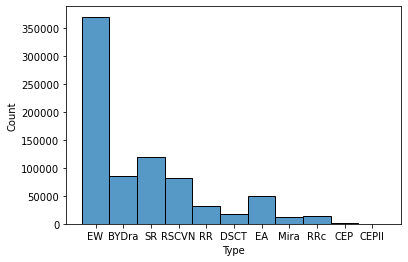

In [13]:
import seaborn as sns
sns.histplot(data=labeled_data, x=labeled_data.Type)

In [14]:
labeled_data.Type.value_counts()

EW       369707
SR       119261
BYDra     84696
RSCVN     81393
EA        49943
RR        32518
DSCT      16709
RRc       13875
Mira      11879
CEP        1262
CEPII       358
Name: Type, dtype: int64